<a href="https://colab.research.google.com/github/thesofakillers/ML_Classifier-Pegasus-Generator/blob/classifier/coursework_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [0]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=True, batch_size=16, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=False, batch_size=16, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

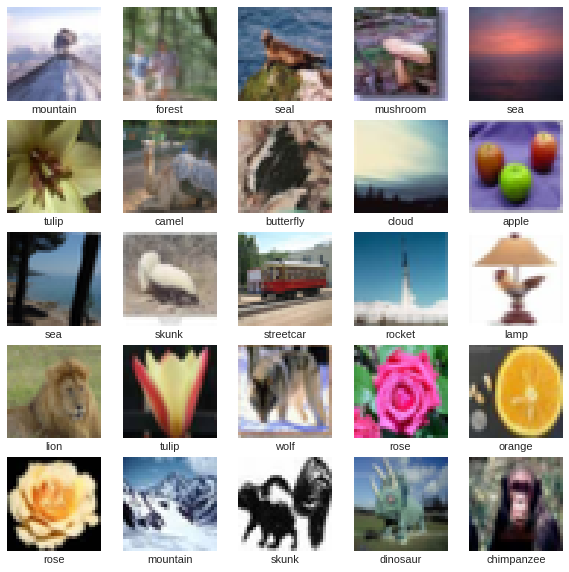

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define a simple model**

In [0]:
# define the model (a simple classifier)
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Linear(in_features=3*32*32, out_features=512))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=512, out_features=100))
        self.layers = layers

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten input as we're using linear layers
        for m in self.layers:
            x = m(x)
        return x

N = MyNetwork().to(device)

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.SGD(N.parameters(), lr=0.001)
epoch = 0
liveplot = PlotLosses()

> Number of network parameters 1624676


**Main training and testing loop**

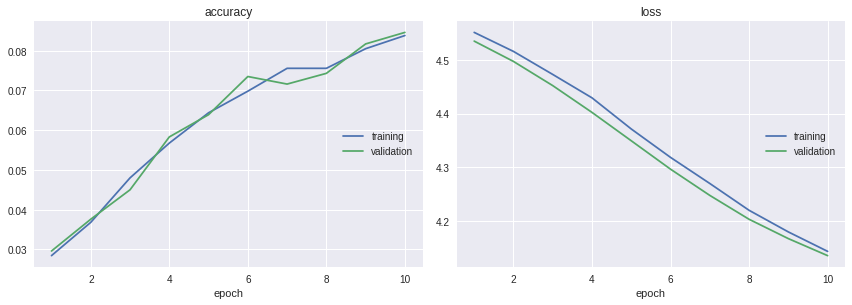

accuracy:
training   (min:    0.028, max:    0.084, cur:    0.084)
validation (min:    0.030, max:    0.085, cur:    0.085)

loss:
training   (min:    4.143, max:    4.551, cur:    4.143)
validation (min:    4.135, max:    4.535, cur:    4.135)


In [0]:
while (epoch<10):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_loss_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # iterate entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)

        p = N(x)
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)

        test_loss_arr = np.append(test_loss_arr, loss.cpu().data)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # NOTE: live plot library has dumb naming forcing our 'test' to be called 'validation'
    liveplot.update({
        'accuracy': train_acc_arr.mean(),
        'val_accuracy': test_acc_arr.mean(),
        'loss': train_loss_arr.mean(),
        'val_loss': test_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Inference on dataset**

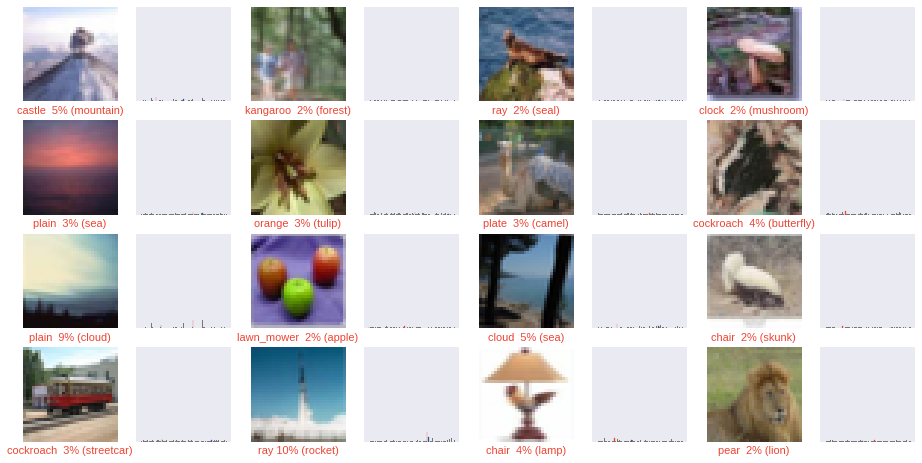

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images).view(test_images.size(0), len(class_names)), dim=1).data.squeeze().cpu().numpy()

num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu(), test_images.cpu().squeeze().permute(1,3,2,0).contiguous().permute(3,2,1,0))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels)